In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

from EconModel import cpptools

do_cpp = True
do_compile = True

In [2]:
# solve model
# TODO: do EGM for singles with storing the marginal value to ensure that that works out as it should
# I think that something might be going wrong with the marginal utility for couples in the EGM. VFI works. I think is is due to the credit constraint not imposed. Implement for singles first to check.

T = 5
model_cpp = brg.HouseholdModelClass(par={'T':T,'phi_w':0.2,'phi_m':0.2,'sigma_love':0.1,'div_A_share':0.3,'do_cpp':True})
model_cpp.link_to_cpp(force_compile=do_compile,do_print=False)
%time model_cpp.solve()

model = brg.HouseholdModelClass(par={'T':T,'phi_w':0.2,'phi_m':0.2,'sigma_love':0.1,'div_A_share':0.3,'do_cpp':False})
%time model.solve()

CPU times: total: 22.5 s
Wall time: 3.36 s
CPU times: total: 1min 11s
Wall time: 1min 11s


## Updating bargaining algorithm in C++

In [3]:
# m = model_cpp
# sol = m.sol
# par = m.par

# t=-2
# #iP=2
# iL=20
# iA=10
# iP = 1

# model_cpp.sol.power[:] = 0.0
# model_cpp.sol.power_idx[:] = 0.0

In [4]:
# model_cpp.cpp.delink()
# model_cpp.link_to_cpp(force_compile=do_compile,do_print=False)

In [5]:
# model_cpp.cpp.recompile()

In [6]:
# model_cpp.cpp.test_divorce(t, iL, iA, iP, par, sol)
# model_cpp.cpp.test_remain(t, iL, iA, iP, par, sol)
# model_cpp.cpp.test_update_to_indifference(3, 0.12, t,iL,iA,iP, par, sol)

# Functions run without errors but do not update sol arrays...

In [7]:
model_cpp.cpp.delink()
model_cpp.link_to_cpp(force_compile=do_compile,do_print=False)
model_cpp.solve()

## Comparing C++ and Python

0.026142095720321112


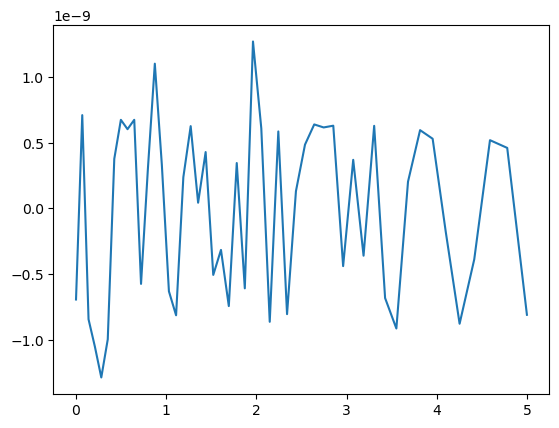

In [8]:
t = model.par.T-1
val = 'Vw_remain_couple'

iP = 10 #10
iL = 5

diff = getattr(model.sol,val) - getattr(model_cpp.sol,val)
plt.plot(model.par.grid_A,diff[t,iP,iL]);
print(np.max(np.abs(diff.ravel())))

In [9]:
# Last period
for val in ('Vw_remain_couple','Vw_couple','Vm_remain_couple','Cw_priv_remain_couple','Cm_priv_remain_couple','C_pub_remain_couple','C_pub_couple','power','Vw_single'):   
    diff = getattr(model.sol,val)[-1] - getattr(model_cpp.sol,val)[-1]
    gns = np.mean(getattr(model_cpp.sol,val)[-1].ravel())
    print(f'{val}: {np.max(np.abs(diff.ravel())):2.5f} (gns: {gns:2.5})')

Vw_remain_couple: 0.00004 (gns: -0.50263)
Vw_couple: 0.05144 (gns: -0.25536)
Vm_remain_couple: 0.00004 (gns: -0.50263)
Cw_priv_remain_couple: 0.00100 (gns: 0.98483)
Cm_priv_remain_couple: 0.00100 (gns: 0.98483)
C_pub_remain_couple: 0.00100 (gns: 2.1824)
C_pub_couple: 1.03000 (gns: 1.7308)
power: 0.00522 (gns: -0.23353)
Vw_single: 0.00000 (gns: -0.52428)


In [10]:
t = 0 # First period
for val in ('Vw_remain_couple','Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_remain_couple','C_pub_couple','power','Vw_single'):
    diff = getattr(model.sol,val)[t] - getattr(model_cpp.sol,val)[t]
    gns = np.mean(getattr(model_cpp.sol,val)[t].ravel())
    print(f'{val}: {np.max(np.abs(diff.ravel())):2.5f} (gns: {gns:2.5})')

# t=0, T=5
# Vw_remain_couple: 0.00193 (gns: -1.6401)
# Vw_couple: 0.00134 (gns: -1.3877)
# Vm_couple: 0.00090 (gns: -1.351)
# Cw_priv_couple: 0.04128 (gns: 0.57543)
# Cm_priv_couple: 0.03040 (gns: 0.61405)
# C_pub_remain_couple: 0.08197 (gns: 1.2784)
# C_pub_couple: 0.21623 (gns: 1.0133)
# power: 0.00155 (gns: -0.16001)
# Vw_single: 0.00000 (gns: -2.6427)

Vw_remain_couple: 0.01909 (gns: -1.6401)
Vw_couple: 0.01909 (gns: -1.3877)
Vm_couple: 0.00090 (gns: -1.351)
Cw_priv_couple: 0.04127 (gns: 0.57543)
Cm_priv_couple: 0.03039 (gns: 0.61405)
C_pub_remain_couple: 0.08197 (gns: 1.2784)
C_pub_couple: 0.21623 (gns: 1.0133)
power: 0.00155 (gns: -0.16001)
Vw_single: 0.00000 (gns: -2.6427)


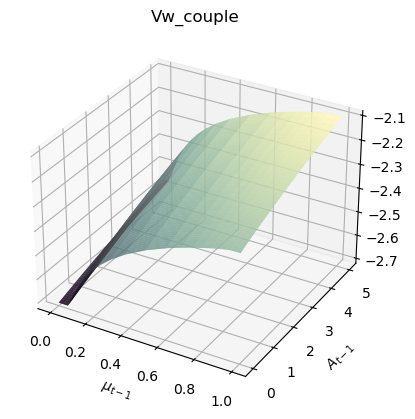

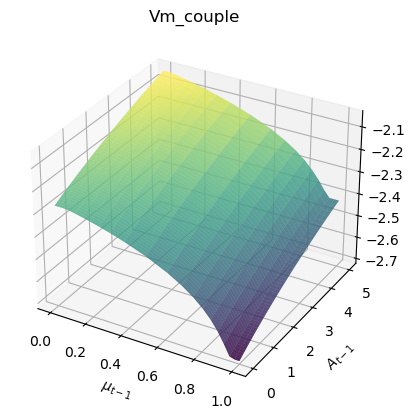

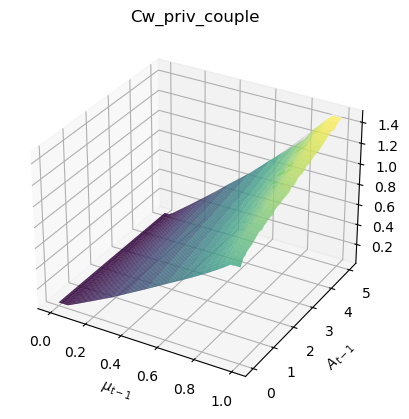

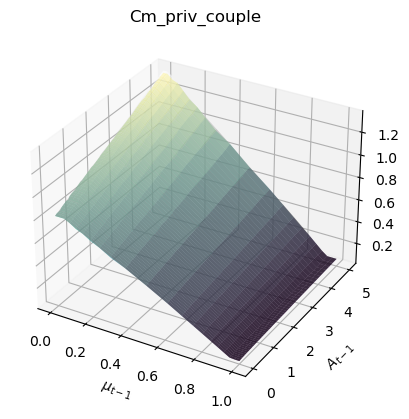

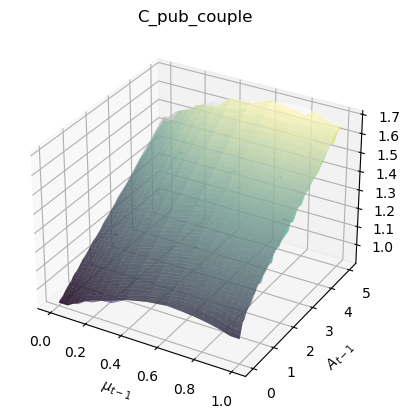

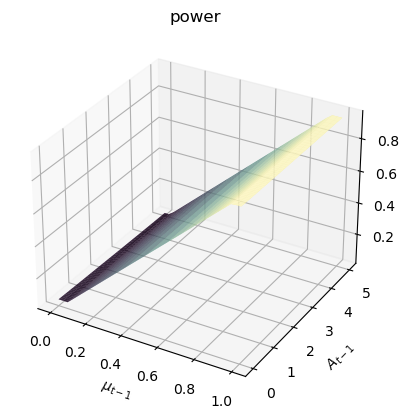

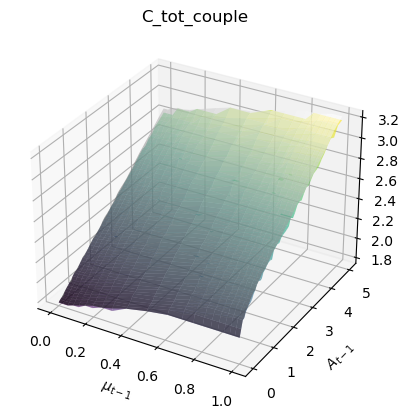

In [11]:
cmaps = ('viridis','gray')
model_list = (model,model_cpp)
t = 0 

par = model.par
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for iL in (par.num_love//2,): 
    for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power','C_tot_couple'):

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        for i,model_now in enumerate(model_list):
       
            Z = getattr(model_now.sol,var)[t,:,iL,:]
            ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=0.6);           
            ax.set(xlabel='$\mu_{t-1}$',ylabel='$A_{t-1}$', title=var);
